In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy import optimize, interpolate, integrate, special
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy.optimize import basinhopping
import warnings

In [2]:
# /data/df.pickleの読み込み
df = pd.read_pickle('../data/df.pickle')

df = df.dropna()

# データの分割
df_p1 = df[(df['started_at'] >= '2020-03-01') & (df['started_at'] < '2020-06-01')].dropna()
df_p2 = df[(df['started_at'] >= '2020-06-01') & (df['started_at'] < '2020-11-01')].dropna()
df_p3 = df[(df['started_at'] >= '2020-12-01') & (df['started_at'] < '2021-03-01')].dropna()
df_p4 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2023-10-01')].dropna()
df_p4_1 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2022-01-01')].dropna()
df_p4_2 = df[(df['started_at'] >= '2022-01-01') & (df['started_at'] < '2023-10-01')].dropna()
df_left = pd.concat([df_p1, df_p2, df_p3, df_p4_1], axis=0)
df_right = pd.concat([df_p4_2], axis=0)

In [3]:
def return_nm(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    # started_atで昇順にソート
    df = df.sort_values(by='started_at')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # node_listにはユニークなstart_station_idを追加
        # df_tmpのstart_station_idをstr型に変換してからユニークな値を取得
        node_list.append(len(df_tmp['start_station_id'].unique()))

        # edge_listにはdf_tmpの行数を追加
        edge_list.append(len(df_tmp))

        current_timestamp = next_timestamp

    # node_listとedge_listで0の値を削除
    node_list = np.array(node_list)
    edge_list = np.array(edge_list)
    timestamp = np.array(timestamp)
    active_node_list = node_list[node_list != 0]
    edge_list = edge_list[edge_list != 0]
    timestamp = timestamp[:len(node_list)]
    
    return active_node_list, edge_list, timestamp

In [4]:
node, edge, timestamp = return_nm(df_right)

In [5]:
# node_leftとedge_leftを組みにしてdf_leftを作成
right = pd.DataFrame({'node': node, 'edge': edge})
# df_leftのnodeを昇順にして並び替え
right = right.sort_values(by='node')
# インデックスを振り直す
right = right.reset_index(drop=True)
right.head()

,node,edge
0,162,263
1,201,340
2,213,378
3,224,479
4,346,857


In [6]:
def Model1(M,kappa):
    def Np(kappa):
        return (1+np.sqrt(1+32*M/kappa))/2
    N = Np(kappa)*(1-2/kappa/Np(kappa)*(1 - (1-kappa/2)**Np(kappa)))
    return N


def Model2(M,Np):
    def kappa(Np):
        return 8*M/Np/(Np-1)
    N = Np*(1 - 2/kappa(Np)/Np*(1 - (1-kappa(Np)/2)**Np))
    return N

In [7]:
params, cov = optimize.curve_fit(Model1, right['edge'], right['node'])
kappa = params[0]
print(kappa)

0.2675572379758786


/Users/yiadka/dev/master_ver2/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/yiadka/dev/master_ver2/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/yiadka/dev/master_ver2/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


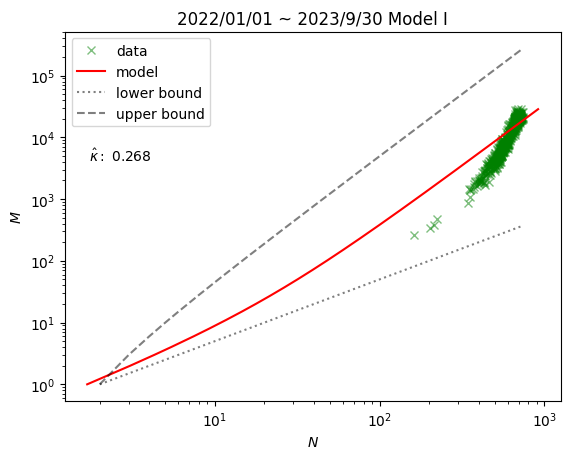

In [8]:
plt.Figure(figsize=(14,7))

N = right['node']
M = right['edge']

x = np.arange(2, np.max(N))
y = np.arange(1, np.max(M))

plt.plot(N, M, "x", c="green", alpha=0.5, label="data")
plt.plot(Model1(y, kappa=kappa), y, label="model", c="red")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
plt.text(0.05, 0.65, r'$\hat{\kappa}:$ ' + str(round(kappa, 3)), transform=plt.gca().transAxes)
plt.xscale("log")
plt.yscale("log")
plt.title("2022/01/01 ~ 2023/9/30 Model I")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.legend()
plt.show()

In [10]:
def residual(params, x, y):
    return y - Model2(x, params[0])

In [11]:
params, _ = optimize.curve_fit(Model2, right['edge'], right['node'], p0=1419)
Np = params[0]
print("Np :", Np)

Np : 621.6152777404341


In [12]:
# least_squaresを用いた最小二乗法
res = optimize.least_squares(residual, x0=600, args=(M, N))
Np = res.x[0]
print("Np :", Np)

Np : 621.615276724925


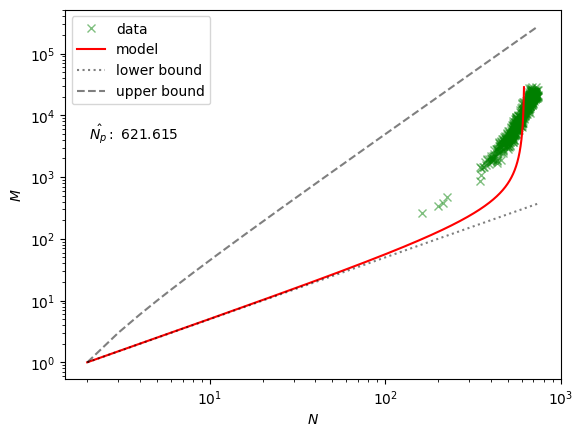

In [13]:
plt.Figure(figsize=(14,7))

N = right['node']
M = right['edge']

x = np.arange(2, np.max(N))
y = np.arange(1, np.max(M))

plt.plot(N, M, "x", c="green", alpha=0.5, label="data")
plt.plot(Model2(y, Np=Np), y, label="model", c="red")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
plt.text(0.05, 0.65, r'$\hat{N_{p}}:$ ' + str(round(Np, 3)), transform=plt.gca().transAxes)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.legend()
plt.show()

In [14]:
Np = 1419
alpha = 0.1
beta = 0.5


def Model3(M):

    def obj(a,i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)

    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i))[0]

    N = Np*(1 - vals)
    return N

def kappa(M, Np):
    return ((alpha+beta)/alpha)**2*2*M/Np/(Np-1)

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_49729/3680295955.py:14: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  vals[i] = integrate.quad(obj, 0,1, args=(i))[0]


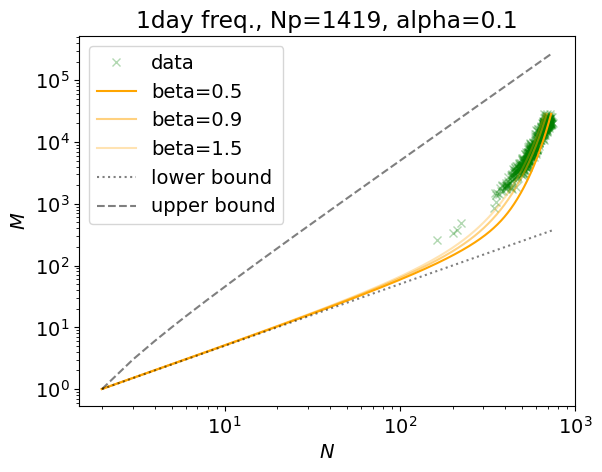

In [15]:
plt.rcParams["font.size"]=14
Np = 1419
x = np.arange(2,np.max(N))
y = np.arange(1,np.max(M))

# data
plt.plot(N, M, "x", c="green", alpha=0.3, label = "data")

# model
alpha = 0.1
beta = 0.5
plt.plot(Model3(y), y, "-", c="orange", label=f"beta={str(beta)}")

alpha = 0.1
beta = 0.9
plt.plot(Model3(y), y, "-", c="orange", label=f"beta={str(beta)}",alpha = 0.5)

alpha = 0.1
beta = 1.5
plt.plot(Model3(y), y, "-", c="orange", label=f"beta={str(beta)}",alpha = 0.3)

# bound and others
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.title("1day freq., Np=1419, alpha=0.1")
plt.legend()

In [16]:
def Model3_fixed(M, alpha, beta):
    def obj(a, i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)
    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i))[0]
    
    N = Np*(1 - vals)
    return N

In [17]:
# Model3_fixedを用いてパラメータを推定
param, cov = optimize.curve_fit(Model3_fixed, M, N, p0=[0.1, 0.5])
print("params: ", param)

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_49729/2291635319.py:7: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  vals[i] = integrate.quad(obj, 0,1, args=(i))[0]
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_49729/2291635319.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  vals[i] = integrate.quad(obj, 0,1, args=(i))[0]


params:  [0.1153342  7.97496586]


/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_49729/3680295955.py:14: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  vals[i] = integrate.quad(obj, 0,1, args=(i))[0]


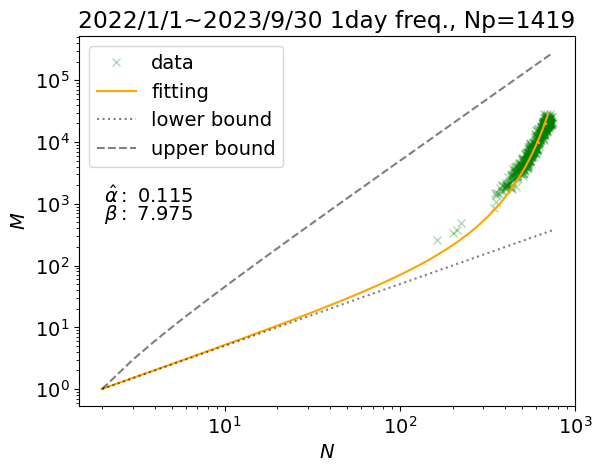

In [20]:
plt.Figure(figsize=(14,7))
Np = 1419
x = np.arange(2,np.max(N))
y = np.arange(1,np.max(M))

# data
plt.plot(N, M, "x", c="green", alpha=0.3, label = "data")


# model
alpha = 0.115
beta = 7.975
plt.plot(Model3(y), y, "-", c="orange", label=f"fitting")
plt.text(0.05, 0.55, r'$\hat{\alpha}:$ ' + str(round(alpha, 3)), transform=plt.gca().transAxes)
plt.text(0.05, 0.50, r'$\hat{\beta}:$ ' + str(round(beta, 3)), transform=plt.gca().transAxes)
"""
alpha = 0.1
beta = 0.9
plt.plot(Model3(y), y, "-", c="orange", label=f"beta={str(beta)}",alpha = 0.5)

alpha = 0.1
beta = 1.5
plt.plot(Model3(y), y, "-", c="orange", label=f"beta={str(beta)}",alpha = 0.3)
"""

# bound and others
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.title("2022/1/1~2023/9/30 1day freq., Np=1419")
plt.legend()